# DSCI 320 Final Project

## Binary Classification

In [386]:
def linear_kernel(X1, X2):
    return np.matmul(X1, X2.T)

def polynomial_kernel(X1, X2, degree=3):
    return (np.matmul(X1, X2.T) + 1) ** degree

def rbf_kernel(X1, X2, gamma=0.1):
    norm = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.matmul(X1, X2.T)
    return np.exp(-gamma * norm)

# Choose your desired kernel function
#kernel_function = linear_kernel
kernel_function = polynomial_kernel  # Uncomment this line to use the polynomial kernel
# kernel_function = rbf_kernel  # Uncomment this line to use the RBF kernel

# Kernel matrix assembly
K_custom = kernel_function(X_train, X_train)

# Use K_custom in place of K_linear in the rest of your code

In [387]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the E. coli data
data_path = r"C:\Users\David\Documents\DSCI 320\Final Project\ecoli.data"
column_names = ["Sequence Name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "Localization"]
df = pd.read_csv(data_path, delim_whitespace=True, names=column_names)

# Display the first few rows
print(df.head())

# Encode the target variable
label_encoder = LabelEncoder()
df["Localization"] = label_encoder.fit_transform(df["Localization"])
X = df.drop(["Sequence Name", "Localization"], axis=1)
y = df["Localization"]

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42, stratify=y)

# Dual problem formulation and solution

N = len(y_train)
XPY = X_train.copy()
for i in range(N):
    if y_train.iloc[i] == -1:
        XPY[i, :] = -1 * X_train[i, :]

A = np.matmul(XPY, XPY.T)
AT = A.T

YM = np.outer(y_train.iloc[1:], y_train.iloc[1:])
AY = np.outer(A[0, 1:], y_train.iloc[1:])
YA = np.outer(y_train.iloc[1:], A[0, 1:])

Y0S = y_train.iloc[0]**2
M = AT[1:, 1:] + A[0, 0] * YM / Y0S - AY / y_train.iloc[0] - YA / y_train.iloc[0]

b = 1 - y_train.iloc[1:] / y_train.iloc[0]

# Solve the linear system for the Lagrange multipliers alpha
alpha = np.linalg.solve(M, b)

# Calculate the alpha_0 term
a1 = -sum(y_train.iloc[1:] * alpha) / y_train.iloc[0]

# Insert alpha_0 at the beginning of the alpha vector
alpha = np.insert(alpha, 0, a1)

# Calculate the weight vector w
aw = np.zeros(N)
for i in range(2, N):
    aw[i] = (1 - y_train.iloc[i] / y_train.iloc[0]) / (
            A[i, i] + A[0, 0] * y_train.iloc[i]**2 / y_train.iloc[0]**2 - 2 * A[0, i] * y_train.iloc[i] / y_train.iloc[0])

aw[0] = -sum(y_train.iloc[1:] * aw[1:]) / y_train.iloc[0]

# Kernel matrix assembly
K_linear = kernel_function

# Display the results
print("Lagrange Multipliers (alpha):", alpha)
print("Weight Vector (w):", aw)
print("Kernel Matrix (K_linear):", K_linear)


  Sequence Name   mcg   gvh   lip  chg   aac  alm1  alm2 Localization
0     AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35           cp
1    ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44           cp
2    ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46           cp
3    ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36           cp
4     ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35           cp
Lagrange Multipliers (alpha): [-8.34986687e+16  2.95598721e+16 -9.65445701e+16  1.15406350e+17
  7.38162082e+16  9.14330572e+16  4.85744202e+15  6.92823616e+16
  4.62946344e+16 -8.07187523e+15  5.74674971e+16  8.65422509e+15
 -5.58645722e+16  4.12508575e+16  2.11032772e+16 -3.30251935e+16
  2.23699876e+15  1.39702883e+16 -1.86823065e+16 -4.42707993e+15
  2.59616074e+17 -1.74354716e+16 -3.05858824e+16  7.36971048e+13
 -5.07647354e+15  6.99686068e+16 -5.99098368e+15 -4.62639352e+16
 -9.26920642e+14 -9.53545747e+16  1.46281716e+16  6.53414707e+15
 -7.16966248e+16 -2.60318453e+

The E. coli dataset is loaded and preprocessed by encoding the target variable and normalizing the features. It then formulates and solves the dual problem for a linear SVM, calculating Lagrange multipliers (alpha), weight vector (aw), and the kernel matrix (K_linear).

In [388]:
YA   = y_train*aw
wght = sum(X_train * YA[:,None])
#wght = sum(xdual_train * YA)

C:\Users\David\AppData\Local\Temp\ipykernel_10448\574577789.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  wght = sum(X_train * YA[:,None])


The weighted sum of the input features X_train is computed using the weight vector aw and target values y_train. It is a step towards calculating the bias term in the SVM.

In [389]:
b =sum(y_train - np.matmul(X_train,wght))/N
#b =sum(ydual_train - xdual_train*wght)/N
yfit = np.matmul(X_train,wght) + b
yfitsign = np.sign(yfit)
ydiff = yfitsign - np.asfarray(y_train)
wherediff = np.where(ydiff != 0)

This code calculates the bias term (b) for the SVM, and then applies the SVM model to the training data to make predictions (yfit). It computes the sign of the predictions and identifies where the predictions differ from the actual labels.

In [390]:
print(wherediff)
print(yfitsign[:15])
print(y_train[:15])
print(len(wherediff[0])/len(y_train))

(array([  1,   3,   4,   6,   7,   8,   9,  10,  11,  13,  14,  15,  16,
        18,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  45,
        46,  47,  49,  50,  51,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  67,  68,  69,  70,  71,  73,  74,  75,  76,
        77,  81,  82,  83,  84,  85,  86,  88,  89,  90,  91,  92,  95,
        96,  97,  98, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 118, 119, 123, 124, 125, 128, 129, 130,
       134, 135, 136, 137, 138, 140, 141, 142, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176,
       177, 178, 179, 180, 181, 186, 187, 188, 189, 190, 191, 193, 194,
       195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 211,
       213, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 2

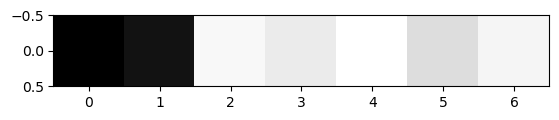

In [391]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(X_train[9][:], [1, 7]), cmap='Greys')

In [392]:
print(wght.shape)

(7,)


In [393]:
mwght = max(wght)
wghtimg=np.reshape(wght, [1,7])

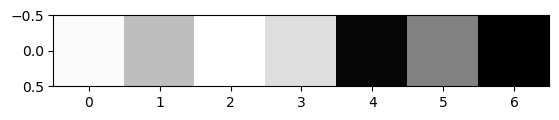

In [394]:
wghtimg = wghtimg*225/mwght
plt.imshow(wghtimg, cmap='Greys')

Prints the indices where the predictions differ from the actual labels. This helps identify which samples the SVM model is having difficulty classifying correctly. The sign (positive or negative) of the first 15 predictions is printed as well. This helps understand the direction of the SVM's predictions.

Then, the code prints the actual labels of the first 15 samples in the training set.

print(len(wherediff[0]) / len(y_train)): Prints the ratio of differing predictions to the total number of samples. This provides an idea of the accuracy or error rate of your SVM model on the training set.

The plot visualizes the 10th row of the normalized training features as a grayscale image. This is often useful for understanding the characteristics of the input features.

Finally, the shape of the weight vector is printed to understand the dimensions of the weight vector and it is then reshaped into a 1x7 matrix.

wghtimg = wghtimg * 225 / mwght: Normalizes the weight vector image to the range [0, 225] for visualization purposes and 
plt.imshow(wghtimg, cmap='Greys') visualizes the weight vector image as a grayscale image. This can provide insights into the importance of different features in the SVM model.

In [423]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create a Support Vector Machine (SVM) classifier
#svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier = SVC(kernel='poly', C=1.0) 
#svm_classifier = SVC(kernel='rbf', C=1.0) 

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' average
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' average
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' average
conf_matrix = confusion_matrix(y_test, y_pred)

print("Performance Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Performance Metrics:
Accuracy: 0.7647058823529411
Precision: 0.8025885792913657
Recall: 0.7647058823529411
F1 Score: 0.7485252309879176
Confusion Matrix:
[[29  0  0  0  0  0]
 [ 1 10  5  0  0  0]
 [ 1  2  4  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 7  0  0  0  0  4]]


## Multiclass Classification
### Without Kernel SVM

In [396]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Number of classes
num_classes = len(np.unique(y_train))

# Dictionary to store classifiers
classifiers = {}

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train one classifier for each class
for i in range(num_classes):
    # Create a binary target variable for the current class
    binary_target = (y_train == i).astype(int)

    # Train a linear SVM for binary classification
    svm = LinearSVC(C=1.0)
    svm.fit(X_train_scaled, binary_target)

    # Store the trained classifier
    classifiers[i] = svm
    print(f"Classifier for class {i} trained successfully.")

# Predictions for each class
class_predictions = {}
for class_label, classifier in classifiers.items():
    # Make predictions using the trained classifier
    class_predictions[class_label] = classifier.predict(X_test_scaled)

# Combine predictions to get the final multiclass prediction
final_predictions = np.vstack(list(class_predictions.values())).T

# Choose the class with the highest confidence for each sample
multiclass_predictions = np.argmax(final_predictions, axis=1)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, multiclass_predictions)
precision = precision_score(y_test, multiclass_predictions, average='weighted')
recall = recall_score(y_test, multiclass_predictions, average='weighted')
f1 = f1_score(y_test, multiclass_predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, multiclass_predictions)

# Print performance metrics
print("Multiclass Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, multiclass_predictions))


Classifier for class 0 trained successfully.
Classifier for class 1 trained successfully.
Classifier for class 2 trained successfully.
Classifier for class 3 trained successfully.
Classifier for class 4 trained successfully.
Classifier for class 5 trained successfully.
Classifier for class 6 trained successfully.
Classifier for class 7 trained successfully.
Multiclass Accuracy: 0.8382352941176471
Precision: 0.8734764175940646
Recall: 0.8382352941176471
F1-Score: 0.8282960911637383

Confusion Matrix:
[[29  0  0  0  0  0]
 [ 1 12  3  0  0  0]
 [ 1  0  6  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 6  0  0  0  0  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        29
           1       1.00      0.75      0.86        16
           4       0.67      0.86      0.75         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7      

C:\Users\David\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\svm\_clas

### With Kernel SVM

In [397]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Number of classes
num_classes = len(np.unique(y_train))

# Dictionary to store classifiers
classifiers = {}

# Train one classifier for each class
for i in range(num_classes):
    # Create a binary target variable for the current class
    binary_target = (y_train == i).astype(int)

    # Train a linear SVM for binary classification
    # You can experiment with different kernels by uncommenting the appropriate line
    # 'linear' kernel is chosen here, but you can try 'poly' or 'rbf'
    print(f"Training SVM for class {i} with binary target:\n{binary_target}")
    
    # svm = SVC(kernel='linear', C=1.0)
    svm = SVC(kernel='rbf', C=1.0)
    # svm = SVC(kernel='rbf', C=1.0)
    svm.fit(X_train, binary_target)

    # Store the trained classifier
    classifiers[i] = svm
    print(f"Classifier for class {i} trained successfully.")

# Predictions for each class
class_predictions = {}
for class_label, classifier in classifiers.items():
    # Make predictions using the trained classifier
    class_predictions[class_label] = classifier.predict(X_test)

# Combine predictions to get the final multiclass prediction
final_predictions = np.vstack(list(class_predictions.values())).T

# Choose the class with the highest confidence for each sample
multiclass_predictions = np.argmax(final_predictions, axis=1)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, multiclass_predictions)
precision = precision_score(y_test, multiclass_predictions, average='weighted')
recall = recall_score(y_test, multiclass_predictions, average='weighted')
f1 = f1_score(y_test, multiclass_predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, multiclass_predictions)

# Print performance metrics
print("Multiclass Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, multiclass_predictions))


Training SVM for class 0 with binary target:
191    0
135    1
203    0
28     1
80     1
      ..
296    0
42     1
192    0
313    0
119    1
Name: Localization, Length: 268, dtype: int32
Classifier for class 0 trained successfully.
Training SVM for class 1 with binary target:
191    1
135    0
203    1
28     0
80     0
      ..
296    0
42     0
192    1
313    0
119    0
Name: Localization, Length: 268, dtype: int32
Classifier for class 1 trained successfully.
Training SVM for class 2 with binary target:
191    0
135    0
203    0
28     0
80     0
      ..
296    0
42     0
192    0
313    0
119    0
Name: Localization, Length: 268, dtype: int32
Classifier for class 2 trained successfully.
Training SVM for class 3 with binary target:
191    0
135    0
203    0
28     0
80     0
      ..
296    0
42     0
192    0
313    0
119    0
Name: Localization, Length: 268, dtype: int32
Classifier for class 3 trained successfully.
Training SVM for class 4 with binary target:
191    0
135   

## Custom SVM Implementation

In [426]:
class SGDClassifier:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.support_vectors_indices = []

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0.0

        for _ in range(self.max_iter):
            for i in range(num_samples):
                if y[i] * (np.dot(X[i], self.weights) + self.bias) < 1:
                    # Update weights and bias using the gradient
                    self.weights = self.weights + self.learning_rate * (
                        y[i] * X[i] - 2 * self.weights / num_samples
                    )
                    self.bias = self.bias + self.learning_rate * y[i]

        # Identify support vectors
        self.support_vectors_indices = [i for i in range(num_samples) if y[i] * (np.dot(X[i], self.weights) + self.bias) < 1]

        # Reshape weights to ensure correct dimensions
        self.weights = self.weights.reshape(1, -1)

    def predict(self, X):
        return np.sign(np.dot(X, self.weights.flatten()) + self.bias)


class CustomSVM:
    def __init__(self, C=1.0, kernel=None, degree=3, gamma=None, learning_rate=0.01, max_iter=1000):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.classes = None
        self.classifiers = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for class_label in self.classes:
            # Convert to binary classification task
            binary_target = np.where(y == class_label, 1, -1)
            classifier = self._train_classifier(X, binary_target)
            self.classifiers[class_label] = classifier

    def _train_classifier(self, X, y):
        if self.kernel is None:
            kernel_function = self._linear_kernel
        elif self.kernel == 'poly':
            kernel_function = self._polynomial_kernel
        elif self.kernel == 'rbf':
            kernel_function = self._rbf_kernel
        else:
            raise ValueError(f"Unsupported kernel: {self.kernel}")

        # Compute the kernel matrix
        kernel_matrix = kernel_function(X, X)
        if self.kernel == 'rbf':
            kernel_matrix = kernel_matrix * np.outer(y, y)  # Multiply by binary targets

        # Initialize the classifier
        classifier = SGDClassifier(learning_rate=self.learning_rate, max_iter=self.max_iter)

        # Train the classifier using the kernelized data
        classifier.fit(X, y)

        return classifier

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _polynomial_kernel(self, X1, X2):
        return (np.dot(X1, X2.T) + 1) ** self.degree
    
    def _rbf_kernel(self, X1, X2):
        # Ensure gamma is set
        if self.gamma is None:
            raise ValueError("Gamma must be specified for RBF kernel.")

        # Compute the pairwise squared Euclidean distances
        distances = np.sum(X1 ** 2, axis=1, keepdims=True) + np.sum(X2 ** 2, axis=1) - 2 * np.dot(X1, X2.T)

        # Apply the RBF kernel formula
        return np.exp(-self.gamma * distances)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.classes)))

        for i, class_label in enumerate(self.classes):
            binary_predictions = self.classifiers[class_label].predict(X)
            predictions[:, i] = binary_predictions

        multiclass_predictions = np.argmax(predictions, axis=1)
        return multiclass_predictions
    
    def plot_support_vectors(self, X, y):
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k', marker='o', s=50)

        for class_label, classifier in self.classifiers.items():
            support_indices = classifier.support_vectors_indices
            support_vectors = X[support_indices]
            plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c='none', cmap=plt.cm.Paired, edgecolors='red', marker='o', s=200, linewidths=3)

        plt.title('Support Vectors')
        plt.show()


C:\Users\David\AppData\Local\Temp\ipykernel_10448\1748613902.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c='none', cmap=plt.cm.Paired, edgecolors='red', marker='o', s=200, linewidths=3)


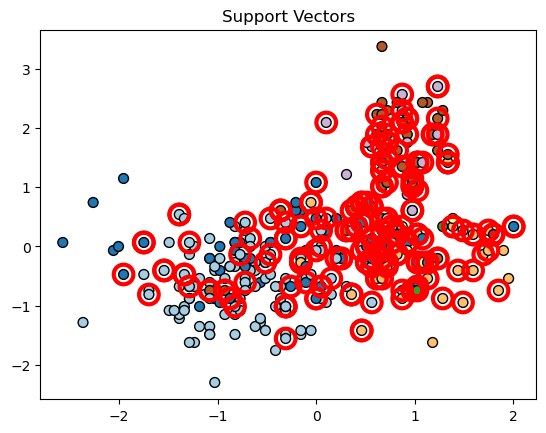

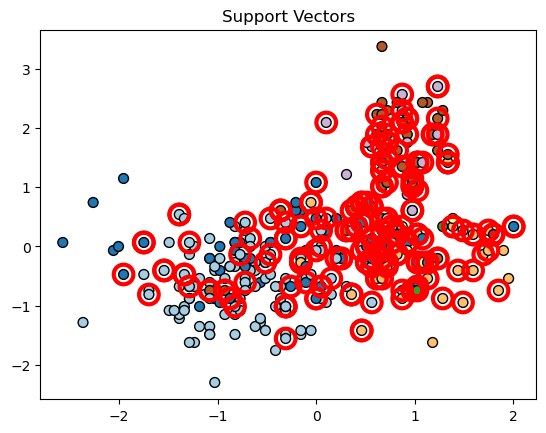

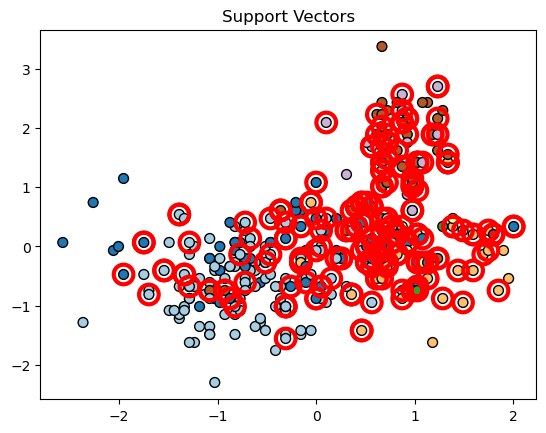

Accuracy: 0.8235294117647058
Precision: 0.8646800825593396
Recall: 0.8235294117647058
F1-Score: 0.8078739704837159

Confusion Matrix:
[[29  0  0  0  0  0]
 [ 1 12  3  0  0  0]
 [ 1  0  6  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 7  0  0  0  0  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.87        29
           1       1.00      0.75      0.86        16
           4       0.67      0.86      0.75         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      0.36      0.53        11

    accuracy                           0.82        68
   macro avg       0.90      0.83      0.83        68
weighted avg       0.86      0.82      0.81        68



In [427]:
# Instantiate and train the model
svm = CustomSVM(C=1.0, learning_rate=0.01, max_iter=1000)
#svm = CustomSVM(C=1.0, kernel='poly', degree=3, learning_rate=0.01, max_iter=1000)
#svm = CustomSVM(C=1.0, kernel='rbf', gamma=0.01, learning_rate=0.01, max_iter=1000)
svm.fit(X_train, y_train)
# Make predictions
predictions = svm.predict(X_test)

svm_2d = CustomSVM(C=1.0, learning_rate=0.01, max_iter=1000)
svm_2d.fit(X_train, y_train)
svm_2d.plot_support_vectors(X_train, y_train)

svm_2d_poly = CustomSVM(C=1.0, kernel='poly', degree=3, learning_rate=0.01, max_iter=1000)
svm_2d_poly.fit(X_train, y_train)
svm_2d_poly.plot_support_vectors(X_train, y_train)

svm_2d_rbf = CustomSVM(C=1.0, kernel='rbf', gamma=0.01, learning_rate=0.01, max_iter=1000)
svm_2d_rbf.fit(X_train, y_train)
svm_2d_poly.plot_support_vectors(X_train, y_train)

# Evaluate performance
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, predictions)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

# Print detailed classification report
report = classification_report(y_test, predictions)
print("\nClassification Report:\n", report)
